# Synthetic data. Previous study.

https://github.com/albertovpd/viu_tfm-deep_vision_classification/tree/synthetic_data_study


In [1]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 16 12:54:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libs

In [4]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import load_model # Sequential
from tensorflow.keras import layers 

# optimization
from tensorflow.keras.optimizers import SGD #Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# nn architectures, metrics, viz & reports => written in my_functions202202 file
import sys
sys.path.append("/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src")
from my_functions202202 import generic_last_2layers, plotting_model, model_evaluation, classification_report_pic, confusion_matrix_report

import numpy as np
%matplotlib inline

# navigating through folder
import os

- paths

In [5]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
test_folder = base_folder+"input/dataset_1test_5trainval_folders/test_ds/"
print(test_folder)
# regular folders for train set
reg_input = base_folder+"input/dataset_1test_5trainval_folders/train_val_ds/trainval_regular_partitions/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/test_ds/


In [6]:
output_folder

'/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision//output/'

- functions

In [7]:
#my_functions202202.py

- common parameters

In [8]:
image_size = (128,128)
batch_size = 128
epochs = 250
opt = SGD(momentum=0.9) 

In [9]:
# available models
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(output_folder) if (isfile(join(output_folder, f)) & (".h5" in f) )]

for files in sorted(onlyfiles):
  print(files)

resnet50_NOdataAug_NOdropout.h5
resnet50_NOdataAug_dropoutFirst007.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold0.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold1.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold2.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold3.h5
resnet50_NOdataAug_dropoutFirst007_regKfolds_fold4.h5
resnet50_NOdataAug_dropoutFirst02.h5
resnet50_NOdataAug_dropoutMid02.h5
resnet50_dataAug_NOdropout.h5
resnet50_dataAug_dropoutFirst02.h5
resnet50_dataAug_dropoutMid02.h5
vgg19_NOdataAug_NOdropout_gelu.h5
vgg19_NOdataAug_dropoutFirst02.h5
vgg19_dataAug_dropoutFirst02.h5
vgg19_dataAug_dropoutFirst02_gelu.h5


In [10]:
# take the model for folder1
#base_model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) 
models_dict = {"resnet50_NOdataAug_dropoutFirst007": 
         load_model(output_folder+"resnet50_NOdataAug_dropoutFirst007.h5")
         }
nn = models_dict["resnet50_NOdataAug_dropoutFirst007"]
name = "resnetfold1_overfold4"

In [12]:
# 150 pics of each class unmutable
print("test_dataset:")
test_ds = image_dataset_from_directory(
    test_folder,
      class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
      seed=None,
      validation_split=None, 
      subset=None,
      image_size= image_size,
      batch_size= batch_size,
      color_mode='rgb',
      shuffle=False 
  )

# apply model from folder1 to pics of folder4
f= "fold4"
train_path = reg_input+f+"/"+'train_ds/'
print("\n train dataset:", "\n", train_path)
train_ds_fold4 = image_dataset_from_directory(
    train_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
    )

val_path = reg_input+f+"/"+"val_ds"
print("\n val dataset:", "\n", val_path)
val_ds_fold4 = image_dataset_from_directory(
  val_path,
  class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
  seed=None,
  validation_split=None, 
  subset=None,
  image_size= image_size,
  batch_size= batch_size,
  color_mode='rgb',
  shuffle=False 
)

class_names = train_ds_fold4.class_names
print(class_names)

test_dataset:
Found 750 files belonging to 5 classes.

 train dataset: 
 /content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/train_val_ds/trainval_regular_partitions/fold4/train_ds/
Found 3598 files belonging to 5 classes.

 val dataset: 
 /content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_1test_5trainval_folders/train_val_ds/trainval_regular_partitions/fold4/val_ds
Found 911 files belonging to 5 classes.
['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']


# Tests

- evaluation

In [13]:
# saving model metrics to json
evaluation = nn.evaluate(val_ds_fold4, batch_size=batch_size, return_dict=True)
model_evaluation(evaluation, output_folder, name+"_trainVal")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 5s 240ms/step - loss: 16.4311 - accuracy: 0.8386


{'resnetfold1_overfold4_trainVal': {'accuracy': 0.8386388421058655,
  'loss': 16.43108367919922}}

- inferences

In [14]:
# over train set fold1
y_pred_float_train_fold4 = nn.predict(train_ds_fold4)
y_pred_train_fold4 = np.argmax(y_pred_float_train_fold4, axis=1)

In [15]:
y_pred_float_train_fold4

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [1.4751815e-18, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.3054316e-21],
       [1.5775043e-06, 9.9999845e-01, 5.5085017e-24, 0.0000000e+00,
        0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00],
       [7.0853388e-36, 3.0311517e-25, 1.4388740e-08, 1.0000000e+00,
        2.0298984e-21],
       [0.0000000e+00, 3.6672611e-32, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [16]:
y_pred_train_fold4

array([1, 1, 1, ..., 3, 3, 3])

In [19]:
# get real labels
y_target_train_fold4 = tf.concat([y for x, y in train_ds_fold4], axis=0) 
y_target_train_fold4

<tf.Tensor: shape=(3598,), dtype=int32, numpy=array([1, 1, 1, ..., 3, 3, 3], dtype=int32)>

              precision    recall  f1-score   support

     Bedroom       0.87      0.92      0.90       833
    Bathroom       0.84      0.93      0.88       326
     Dinning       0.75      0.90      0.82       676
  Livingroom       0.85      0.81      0.83       946
     Kitchen       0.90      0.72      0.80       817

    accuracy                           0.84      3598
   macro avg       0.84      0.86      0.85      3598
weighted avg       0.85      0.84      0.84      3598



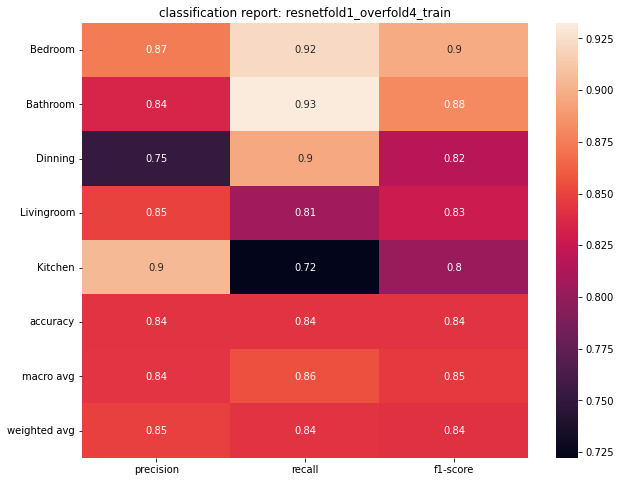

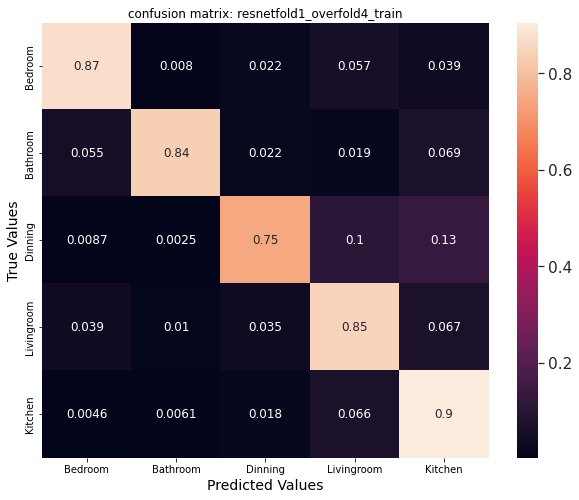

In [20]:
# classification and confusion matrix reports
classification_report_pic(y_pred_train_fold4, y_target_train_fold4, class_names, output_folder, name+"_train")
confusion_matrix_report(  y_pred_train_fold4, y_target_train_fold4, class_names, output_folder, name+"_train")

- over val ds

In [21]:
# over val set fold1
y_pred_float_val_fold4 = nn.predict(val_ds_fold4)
y_pred_val_fold4 = np.argmax(y_pred_float_val_fold4, axis=1)

In [22]:
y_pred_float_val_fold4

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.7912302e-16],
       [4.5536503e-32, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.7711717e-21],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 3.0709083e-33, 1.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [23]:
y_pred_val_fold4

array([1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 4,
       0, 3, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0,

In [24]:
# get real labels
y_target_val_fold4 = tf.concat([y for x, y in val_ds_fold4], axis=0) 
y_target_val_fold4

<tf.Tensor: shape=(911,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

              precision    recall  f1-score   support

     Bedroom       0.84      0.90      0.87       214
    Bathroom       0.85      0.93      0.89        84
     Dinning       0.75      0.88      0.81       172
  Livingroom       0.85      0.80      0.82       241
     Kitchen       0.92      0.75      0.83       200

    accuracy                           0.84       911
   macro avg       0.84      0.85      0.84       911
weighted avg       0.84      0.84      0.84       911



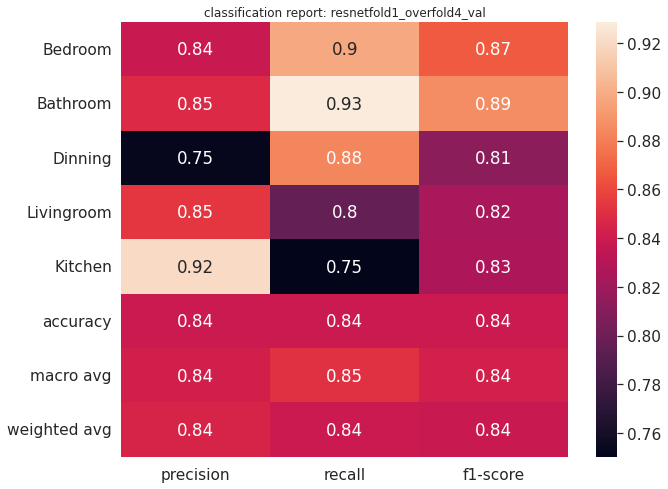

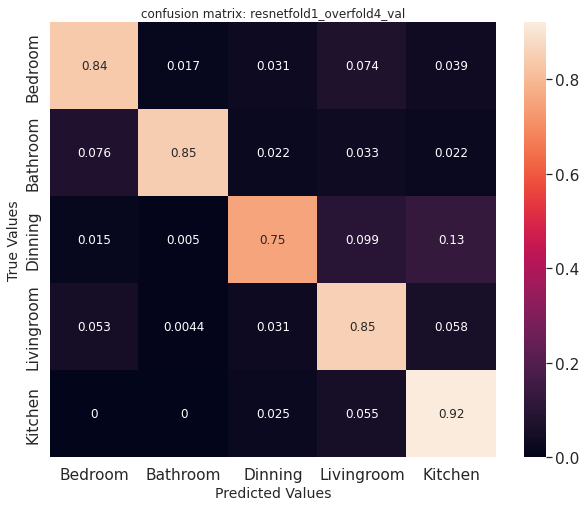

In [25]:
# classification and confusion matrix reports
classification_report_pic(y_pred_val_fold4, y_target_val_fold4, class_names, output_folder, name+"_val")
confusion_matrix_report(  y_pred_val_fold4, y_target_val_fold4, class_names, output_folder, name+"_val")

In [ ]:
what to do now?